# Setting Up the Notebook

In this initial setup, we'll install and import MLFlow in order to track the experiment and log the results of the training.

In [ ]:
pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gc
import nibabel as nib

In [ ]:
!pip install mlflow --quiet

import mlflow
import os
from getpass import getpass

os.environ['MLFLOW_TRACKING_USERNAME'] = input('Enter your DAGsHub username: ')
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Enter your DAGsHub access token: ')
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = input('Enter your DAGsHub project name: ')

mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME'] 
                        + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')

     |████████████████████████████████| 17.0 MB 5.1 MB/s 
     |████████████████████████████████| 79 kB 8.0 MB/s 
     |████████████████████████████████| 77 kB 6.3 MB/s 
     |████████████████████████████████| 146 kB 67.7 MB/s 
     |████████████████████████████████| 209 kB 45.4 MB/s 
     |████████████████████████████████| 181 kB 67.6 MB/s 
     |████████████████████████████████| 78 kB 7.6 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 59 kB 6.3 MB/s 
Enter your DAGsHub username: montanarograziano
Enter your DAGsHub access token: ··········
Enter your DAGsHub project name: Thesis


Similarly to previous notebooks, we can then import some useful libraries and set the base directory containing the dataset, as well as the random seed.

In [ ]:
import random
from pathlib import Path
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


DATA_DIR = Path("Your data Directory")
RANDOM_SEED = 1234
random.seed(RANDOM_SEED)

Before proceeding, we need to mount the Google Drive folder. Here we've chosen as mountpoint the folder `/datasets/drive`.

In [ ]:
!mkdir /datasets -p
from google.colab import drive
drive.mount('/datasets/drive', force_remount=True)

Mounted at /datasets/drive


We can then import the TensorFlow library.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
#tf.config.run_functions_eagerly(True) #Necessary for Grad-CAM

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


And check that we're runnning the 2.6 version on the Nvidia Tesla P100 GPU.

In [ ]:
print("Tensorflow version:", tf.__version__)
gpus = !nvidia-smi --query-gpu=gpu_name --format=csv,noheader
print("Available GPUs:",
      len(tf.config.list_physical_devices('GPU')),
      f"({','.join(gpus)})")

Tensorflow version: 2.8.2
Available GPUs: 1 (Tesla T4)


# Training the Model

## Building the Model

We can define a simple function to build the model that will be trained in the next steps.

The frozen model is used for the Transfer Learning experiments, as it's convolutional layers are freezed and only the FC layers are trained.

In [ ]:
def get_3d_frozen(width=128, height=128, depth=50):
    """Build a convolutional neural network model based on the Zunhair et al model.
    References
    ----------
    - https://arxiv.org/abs/2007.13224
    """
    inputs = keras.Input((width, height, depth,1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu",trainable=False)(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization(trainable=False)(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", trainable=False)(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization(trainable=False)(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu", trainable=False)(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization(trainable=False)(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu", trainable=False)(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization(trainable=False)(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="mri-transfer")
    return model

In [ ]:
def get_3d_model(width=128, height=128, depth=50):
    """Build a convolutional neural network model based on the Zunhair et al model.
    References
    ----------
    - https://arxiv.org/abs/2007.13224
    """
    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="mri-validation")
    return model

The 3D model takes images of *128x128x50* shape.
- **Learning rate** is set to *5e-5* (the best one after some initial tuning)
- **Early stopping** is set to a patience value of 35 epochs on *validation accuracy*
- **Binary crossentropy** is used as loss function, optimized with the **Adam** optimizer.

In [ ]:
# Compile model.
def train_3d_model(x_train, y_train, x_test, y_test, epochs=10000, verbose=2, batch_size=32, run_name="run", filename="3d_image_classification.h5"):
    # Build model.
    mlflow.tensorflow.autolog()
    with mlflow.start_run(run_name=run_name):
        model = get_3d_model(width=128, height=128, depth=50)

        train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))


        train_dataset = (
            train_loader.shuffle(len(x_train), seed=RANDOM_SEED)
            .batch(batch_size)
            .prefetch(4)
        )
        validation_dataset = (
            validation_loader.shuffle(len(x_test), seed=RANDOM_SEED)
            .batch(batch_size)
            .prefetch(4)
        )

        initial_learning_rate = 5e-5 # from https://doi.org/10.3938/jkps.75.597
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
        )
        model.compile(
            loss="binary_crossentropy",
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            metrics=['acc']
        )

        # Define callbacks.
        checkpoint_cb = keras.callbacks.ModelCheckpoint(
            filename, monitor="val_acc", save_best_only=True
        )
        early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=35, min_delta=0.001, baseline=0.60)

        # Train the model, doing validation at the end of each epoch
        history = model.fit(
            train_dataset,
            validation_data=validation_dataset,
            epochs=epochs,
            shuffle=True,
            verbose=verbose,
            callbacks=[checkpoint_cb, early_stopping_cb],
        )
        tf.keras.backend.clear_session()
        #mlflow.log_artifacts(str(Path(filename).parent))

        model.load_weights(filename)
        metrics = model.evaluate(validation_dataset)
        mlflow.log_metric("val_loss", metrics[0])
        mlflow.log_metric("val_accuracy", metrics[1])
        predictions = model.predict(xtest, batch_size=8, verbose=1)
        t_n, f_p, f_n, t_p = get_matrix(predictions,ytest)
        pred = [t_n,f_p,f_n,t_p]
        mlflow.log_metric("confusion.tn", t_n)
        mlflow.log_metric("confusion.fp", f_p)
        mlflow.log_metric("confusion.fn", f_n)
        mlflow.log_metric("confusion.tp", t_p)
        
        #metrics = model.predict(validation_dataset)

    return history,metrics,pred

## Training Strategy

We can then define a function to compile and train the model by setting some common options.

In [ ]:
# Compile model.
def tuning_3d(x_train, y_train, x_test, y_test, epochs=10000, verbose=2, batch_size=32, run_name="run", filename="3d_image_classification.h5"):
    # Build model.
    mlflow.tensorflow.autolog()
    with mlflow.start_run(run_name=run_name):
        model = get_3d_frozen(width=128, height=128, depth=50)
        model.load_weights(DATA_DIR/'mri/folds/validation/50-mri.h5')

        train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))
        #mri_val = tf.data.Dataset.from_tensor_slices((mri_img,mri_label))


        train_dataset = (
            train_loader.shuffle(len(x_train), seed=RANDOM_SEED)
            .batch(batch_size)
            .prefetch(4)
        )
        validation_dataset = (
            validation_loader.shuffle(len(x_test), seed=RANDOM_SEED)
            .batch(batch_size)
            .prefetch(4)
        )

        initial_learning_rate = 5e-5 # from https://doi.org/10.3938/jkps.75.597
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
        )
        model.compile(
            loss="binary_crossentropy",
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            metrics=['acc']
        )

        # Define callbacks.
        checkpoint_cb = keras.callbacks.ModelCheckpoint(
            filename, monitor='val_acc', save_best_only=True
        )
        early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=20, min_delta=0.001, baseline=0.60)

        # Train the model, doing validation at the end of each epoch
        #history = model.fit(
        #    train_dataset,
        #    validation_data=validation_dataset,
        #    epochs=epochs,
        #    shuffle=True,
        #    verbose=verbose,
        #    callbacks=[checkpoint_cb, early_stopping_cb],
        #)
        tf.keras.backend.clear_session()
        #mlflow.log_artifacts(str(Path(filename).parent))

        model.load_weights(filename)
        metrics = model.evaluate(validation_dataset)
        mlflow.log_metric("val_loss", metrics[0])
        mlflow.log_metric("val_accuracy", metrics[1])
        
        predictions = model.predict(xtest, batch_size=8, verbose=1)
        t_n, f_p, f_n, t_p = get_matrix(predictions,ytest)
        pred = [t_n,f_p,f_n,t_p]
        mlflow.log_metric("confusion.tn", t_n)
        mlflow.log_metric("confusion.fp", f_p)
        mlflow.log_metric("confusion.fn", f_n)
        mlflow.log_metric("confusion.tp", t_p)

    return metrics,pred

## Executing the Experiment

We can finally execute the experiment by running the training on the 10 folds that were saved in the previous steps.

We can then validate the model on the test set

In [ ]:
def plot_results(history):
  fig, ax = plt.subplots(1, 2, figsize=(20, 3))
  ax = ax.ravel()
  for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
  return fig

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score

def sensitivity(matrix):
    tn, fp, fn, tp = matrix.ravel()
    return tp / (tp + fn)
def specificity(matrix):
    tn, fp, fn, tp = matrix.ravel()
    return tn / (tn + fp)

results = []
for k in range(1, 11):
  base = DATA_DIR / f'pet/combined/fold-{k}'
  folder = DATA_DIR / f'pet/combined/results/fold-{k}'
  xtest = np.load(base / 'xtest.npy')
  ytest = np.load(base / 'ytest.npy')
  model = tf.keras.models.load_model(folder / 'combined.h5')
  model.load_weights(folder / 'combined.h5')
  d = get_dataset(xtest,ytest)
  predictions = model.predict(d)
  scores = np.array([[1-p, p] for p in predictions[:,0]])
  mat = confusion_matrix(ytest, np.argmax(scores, axis=1))
  #np.save(folder / 'confusion-matrix.npy', mat)
  results += [(sensitivity(mat), specificity(mat), roc_auc_score(ytest, predictions[:,0]))]
  print(results)

a = np.array(results)
np.mean(a,axis=0)

In [ ]:
np.mean(a,axis=0)

array([0.96382609, 0.96122807, 0.99484851])

In [ ]:
# Testing transfer learning on 3D dataset FROM MRI TO PET with frozen conv
import pandas as pd
base = DATA_DIR / 'pet/'
res = DATA_DIR / 'pet/folds/validation'
xtrain = np.load(base / '50f-xtrain.npy')
xtest = np.load(base / '50f-xtest.npy')
ytrain = np.load(base / '50-ytrain.npy')
ytest = np.load(base / '50-ytest.npy')
tf.keras.backend.clear_session()
metrics,predictions = train_3d_model(xtrain, ytrain, xtest, ytest, batch_size=4, run_name="validation", filename=str(res / "50-pet.h5"), verbose=2)
#val_df = pd.DataFrame(hist.history)
#val_df.to_csv(res/'3d-folds/mri-transfer.csv')

8/8 [==============================] - 1s 83ms/step
tf.Tensor(
[[26  4]
 [ 7 23]], shape=(2, 2), dtype=int32)


In [ ]:
# New training on 3D MRI
for k in range(1,11):
  base = DATA_DIR / f'pet/3d-folds/50/fold-{k}'
  xtrain = np.load(base / 'xtrain.npy')
  xtest = np.load(base / 'xtest.npy')
  ytrain = np.load(base / 'ytrain.npy')
  ytest = np.load(base / 'ytest.npy')
  results = DATA_DIR / f'pet/3d-folds/50/results/fold-{k}'
  tf.keras.backend.clear_session()
  model,metrics = train_3d_model(xtrain, ytrain, xtest, ytest, batch_size=4, run_name=f"fold-{k}", filename=str(results / "memento-pet.h5"), verbose=2)
#val_df = pd.DataFrame(model.history)
#val_df.to_csv(base/'3d-folds/50-val.csv')

In [ ]:
model = pd.read_csv(DATA_DIR/'mri/3d-folds/mri-transfer.csv')

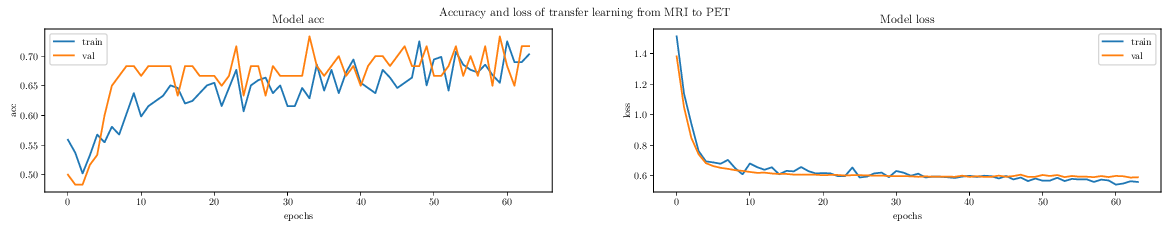

In [ ]:
f = plot_folds(model)
plt.suptitle("Accuracy and loss of transfer learning from MRI to PET")
plt.show()
plt.savefig(DATA_DIR/'mri/3d-folds/mri-transfer.pgf')

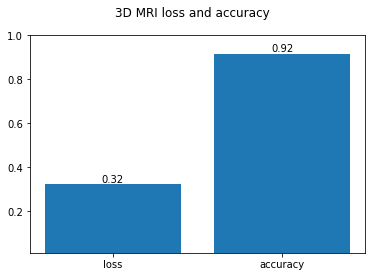

In [ ]:
plt.bar(['loss','accuracy'], metrics)
plt.text('loss', metrics[0], f"{metrics[0]:.2f}", ha='center', va='bottom')
plt.text('accuracy', metrics[1], f"{metrics[1]:.2f}", ha='center', va='bottom')
plt.suptitle("3D MRI loss and accuracy")
plt.ylim(0.01, 1)
plt.show()

## From MRI to PET transfer

In [ ]:
# Testing transfer learning on 3D dataset FROM MRI TO PET with frozen conv
import pandas as pd
base = DATA_DIR / 'pet/'
res = DATA_DIR / 'mri/'
xtrain = np.load(base / '50f-xtrain.npy')
xtest = np.load(base / '50f-xtest.npy')
ytrain = np.load(base / '50-ytrain.npy')
ytest = np.load(base / '50-ytest.npy')
tf.keras.backend.clear_session()
metrics,predictions = tuning_3d(xtrain, ytrain, xtest, ytest, batch_size=4, run_name="mri-transfer", filename=str(res / f"3d-folds/mri-transfer.h5"), verbose=2)
#val_df = pd.DataFrame(hist.history)
#val_df.to_csv(res/'3d-folds/mri-transfer.csv')

8/8 [==============================] - 1s 82ms/step
tf.Tensor(
[[18 12]
 [ 6 24]], shape=(2, 2), dtype=int32)


In [ ]:
batchsize = 4
print("Batchsize:", batchsize)
for k in range(1, 11):
    base = DATA_DIR / f'pet/3d-folds/50/fold-{k}'
    xtrain = np.load(base / 'xtrain.npy')
    ytrain = np.load(base / 'ytrain.npy')
    xtest = np.load(base / 'xtest.npy')
    ytest = np.load(base / 'ytest.npy')
    tf.keras.backend.clear_session()
    print('k =',k)

    results = DATA_DIR / f'mri/3d-folds/50/results/fold-{k}'
    results.mkdir(exist_ok=True, parents=True)
    metrics,predictions = tuning_3d(xtrain, ytrain, xtest, ytest, batch_size=batchsize, run_name=f"fold-{k}", filename=str(results / f"mri-transfer.h5"), verbose=2)
    #history_df = pd.DataFrame(history.history)
    #history_df.to_csv(results/f'{k}-transfer-history.csv')


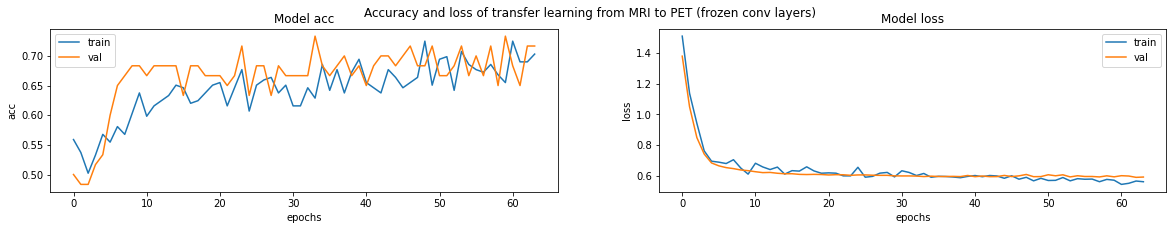

In [ ]:
fig = plot_results(hist)
fig.suptitle("Accuracy and loss of transfer learning from MRI to PET (frozen conv layers)")
plt.show()

Plotting loss and accuracy of transfer learning from MRI to PET

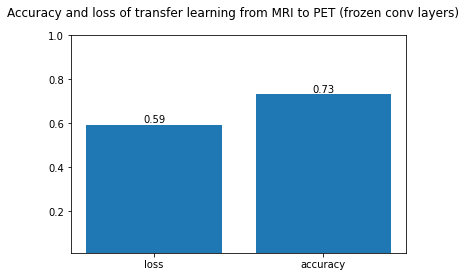

In [ ]:
plt.bar(['loss','accuracy'], mri_metrics)
plt.text('loss', mri_metrics[0], f"{mri_metrics[0]:.2f}", ha='center', va='bottom')
plt.text('accuracy', mri_metrics[1], f"{mri_metrics[1]:.2f}", ha='center', va='bottom')
plt.suptitle("Accuracy and loss of transfer learning from MRI to PET (frozen conv layers)")
plt.ylim(0.01, 1)
plt.show()

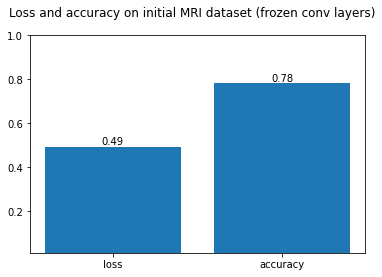

In [ ]:
plt.bar(['loss','accuracy'], metrics)
plt.text('loss', metrics[0], f"{metrics[0]:.2f}", ha='center', va='bottom')
plt.text('accuracy', metrics[1], f"{metrics[1]:.2f}", ha='center', va='bottom')
plt.suptitle("Loss and accuracy on initial MRI dataset (frozen conv layers)")
plt.ylim(0.01, 1)
plt.show()

## From MRI to PET 1 conv layer unfrozen

In [ ]:
# Testing transfer learning on 3D dataset from MRI TO PET with 1 conv unfrozen
import pandas as pd
base = DATA_DIR / 'pet/'
res = DATA_DIR / 'mri/'
xtrain = np.load(base / '50f-xtrain.npy')
xtest = np.load(base / '50f-xtest.npy')
ytrain = np.load(base / '50-ytrain.npy')
ytest = np.load(base / '50-ytest.npy')
mri_img = np.load(res/'50-xtest.npy')
mri_label = np.load(res/'50-ytest.npy')
tf.keras.backend.clear_session()
hist,metrics,mri_metrics = tuning_3d(xtrain, ytrain, xtest, ytest, mri_img,mri_label, batch_size=4, run_name="mri-transfer-conv1", filename=str(res / f"3d-folds/mri-transfer-conv1.h5"), verbose=1)
val_df = pd.DataFrame(hist.history)
val_df.to_csv(res/'3d-folds/mri-transfer-conv1.csv')

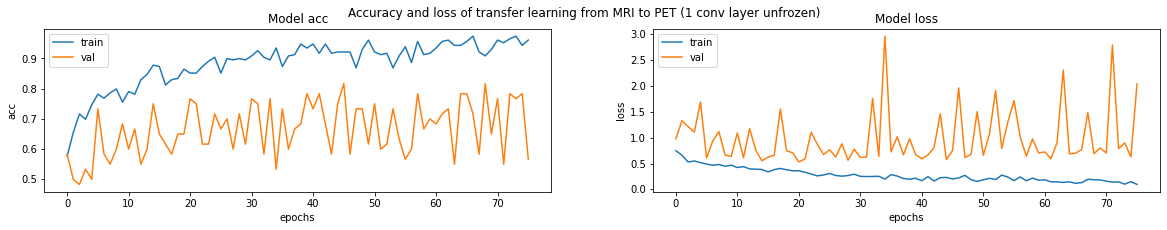

In [ ]:
fig = plot_results(hist)
fig.suptitle("Accuracy and loss of transfer learning from MRI to PET (1 conv layer unfrozen)")
plt.show()

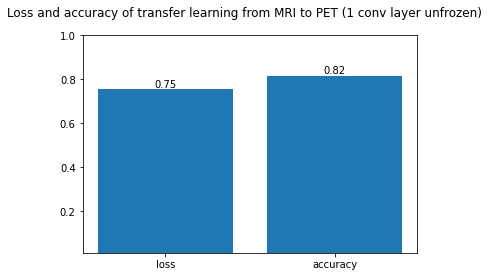

In [ ]:
plt.bar(['loss','accuracy'], metrics)
plt.text('loss', metrics[0], f"{metrics[0]:.2f}", ha='center', va='bottom')
plt.text('accuracy', metrics[1], f"{metrics[1]:.2f}", ha='center', va='bottom')
plt.suptitle("Loss and accuracy of transfer learning from MRI to PET (1 conv layer unfrozen)")
plt.ylim(0.01, 1)
plt.show()

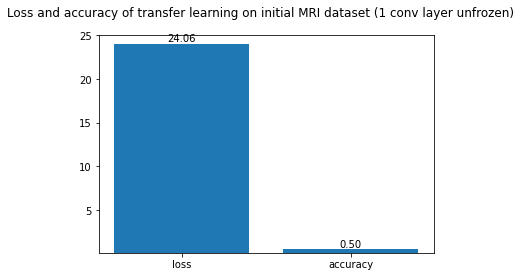

In [ ]:
plt.bar(['loss','accuracy'], mri_metrics)
plt.text('loss', mri_metrics[0], f"{mri_metrics[0]:.2f}", ha='center', va='bottom')
plt.text('accuracy', mri_metrics[1], f"{mri_metrics[1]:.2f}", ha='center', va='bottom')
plt.suptitle("Loss and accuracy of transfer learning on initial MRI dataset (1 conv layer unfrozen)")
plt.ylim(0.1,25)
plt.show()

## From MRI to PET 2 conv layers unfrozen

In [ ]:
# Testing transfer learning on 3D dataset from MRI TO PET with 2 conv unfrozen
import pandas as pd
base = DATA_DIR / 'pet/'
res = DATA_DIR / 'mri/'
xtrain = np.load(base / '50f-xtrain.npy')
xtest = np.load(base / '50f-xtest.npy')
ytrain = np.load(base / '50-ytrain.npy')
ytest = np.load(base / '50-ytest.npy')
mri_img = np.load(res/'50-xtest.npy')
mri_label = np.load(res/'50-ytest.npy')
tf.keras.backend.clear_session()
hist,metrics,mri_metrics = tuning_3d(xtrain, ytrain, xtest, ytest, mri_img,mri_label, batch_size=4, run_name="mri-transfer-conv2", filename=str(res / f"3d-folds/mri-transfer-conv2.h5"), verbose=0)
val_df = pd.DataFrame(hist.history)
val_df.to_csv(res/'3d-folds/mri-transfer-conv2.csv')


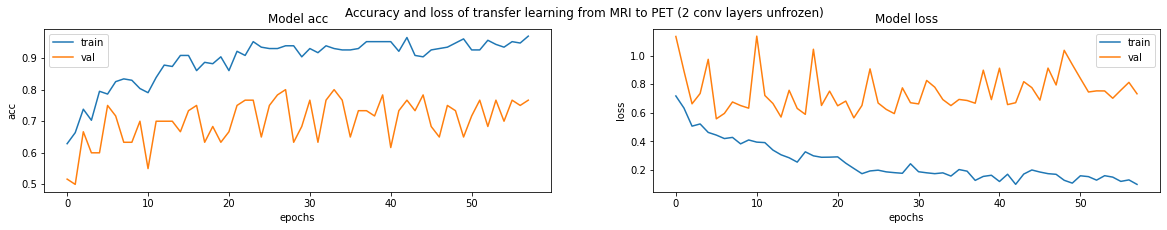

In [ ]:
#inserire andamento loss e acc
fig = plot_results(hist)
fig.suptitle("Accuracy and loss of transfer learning from MRI to PET (2 conv layers unfrozen)")
plt.show()

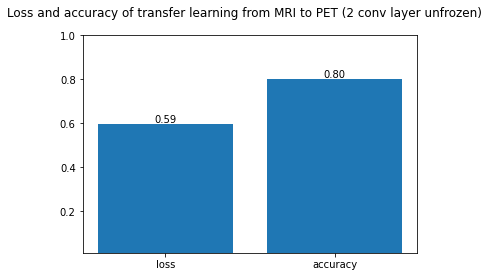

In [ ]:
plt.bar(['loss','accuracy'], metrics)
plt.text('loss', metrics[0], f"{metrics[0]:.2f}", ha='center', va='bottom')
plt.text('accuracy', metrics[1], f"{metrics[1]:.2f}", ha='center', va='bottom')
plt.suptitle("Loss and accuracy of transfer learning from MRI to PET (2 conv layer unfrozen)")
plt.ylim(0.01, 1)
plt.show()

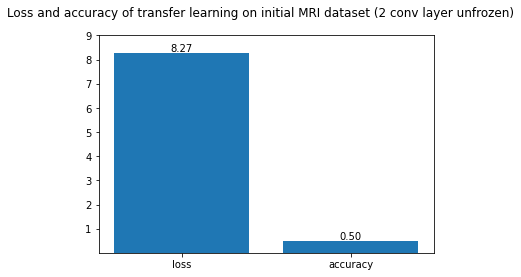

In [ ]:
plt.bar(['loss','accuracy'], mri_metrics)
plt.text('loss', mri_metrics[0], f"{mri_metrics[0]:.2f}", ha='center', va='bottom')
plt.text('accuracy', mri_metrics[1], f"{mri_metrics[1]:.2f}", ha='center', va='bottom')
plt.suptitle("Loss and accuracy of transfer learning on initial MRI dataset (2 conv layer unfrozen)")
plt.ylim(0.01, 9)
plt.show()

## From PET to MRI transfer

In [ ]:
batchsize = 4
print("Batchsize:", batchsize)
for k in range(1, 11):
    base = DATA_DIR / f'mri/3d-folds/50/fold-{k}'
    xtrain = np.load(base / 'xtrain.npy')
    ytrain = np.load(base / 'ytrain.npy')
    xtest = np.load(base / 'xtest.npy')
    ytest = np.load(base / 'ytest.npy')
    tf.keras.backend.clear_session()
    print('k =',k)

    results = DATA_DIR / f'pet/3d-folds/50/results/fold-{k}'
    results.mkdir(exist_ok=True, parents=True)
    metrics,predictions = tuning_3d(xtrain, ytrain, xtest, ytest, batch_size=batchsize, run_name=f"fold-{k}", filename=str(results / f"pet-transfer.h5"), verbose=2)
    #history_df = pd.DataFrame(history.history)
    #history_df.to_csv(results/f'{k}-transfer-history.csv')


Batchsize: 4
k = 1
3/3 [==============================] - 0s 83ms/step
tf.Tensor(
[[11  0]
 [ 5  7]], shape=(2, 2), dtype=int32)
k = 2
3/3 [==============================] - 0s 83ms/step
tf.Tensor(
[[9 2]
 [8 4]], shape=(2, 2), dtype=int32)
k = 3
3/3 [==============================] - 0s 84ms/step
tf.Tensor(
[[10  1]
 [ 1 11]], shape=(2, 2), dtype=int32)
k = 4
3/3 [==============================] - 0s 83ms/step
tf.Tensor(
[[10  1]
 [ 2 10]], shape=(2, 2), dtype=int32)
k = 5
3/3 [==============================] - 0s 83ms/step
tf.Tensor(
[[6 5]
 [6 6]], shape=(2, 2), dtype=int32)
k = 6
3/3 [==============================] - 0s 83ms/step
tf.Tensor(
[[7 5]
 [7 4]], shape=(2, 2), dtype=int32)
k = 7
3/3 [==============================] - 0s 83ms/step
tf.Tensor(
[[ 9  3]
 [ 1 10]], shape=(2, 2), dtype=int32)
k = 8
3/3 [==============================] - 0s 83ms/step
tf.Tensor(
[[ 9  3]
 [ 1 10]], shape=(2, 2), dtype=int32)
k = 9
3/3 [==============================] - 0s 83ms/step
tf.Tensor(
[[

In [ ]:
# Testing transfer learning on 3D dataset FROM PET TO MRI with frozen conv
import pandas as pd
base = DATA_DIR / 'mri/'
res = DATA_DIR / 'pet/'
xtrain = np.load(base / '50-xtrain.npy')
xtest = np.load(base / '50-xtest.npy')
ytrain = np.load(base / '50-ytrain.npy')
ytest = np.load(base / '50-ytest.npy')
pet_img = np.load(res/'50f-xtest.npy')
pet_label = np.load(res/'50-ytest.npy')
tf.keras.backend.clear_session()
metrics,predictions = tuning_3d(xtrain, ytrain, xtest, ytest, batch_size=4, run_name="pet-transfer", filename=str(res / f"3d-folds/pet-transfer.h5"), verbose=1)

8/8 [==============================] - 1s 82ms/step
tf.Tensor(
[[26  4]
 [ 6 24]], shape=(2, 2), dtype=int32)


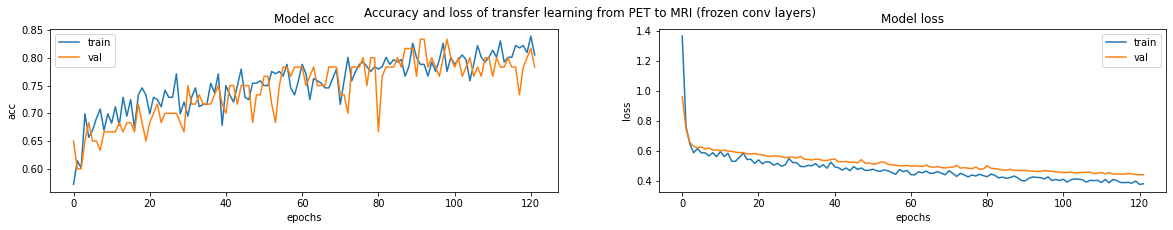

In [ ]:
fig = plot_results(hist)
fig.suptitle("Accuracy and loss of transfer learning from PET to MRI (frozen conv layers)")
plt.show()

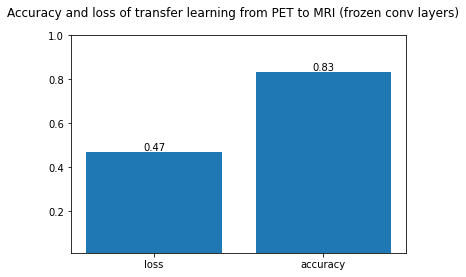

In [ ]:
plt.bar(['loss','accuracy'], pet_metrics)
plt.text('loss', pet_metrics[0], f"{pet_metrics[0]:.2f}", ha='center', va='bottom')
plt.text('accuracy', pet_metrics[1], f"{pet_metrics[1]:.2f}", ha='center', va='bottom')
plt.suptitle("Accuracy and loss of transfer learning from PET to MRI (frozen conv layers)")
plt.ylim(0.01, 1)
plt.show()

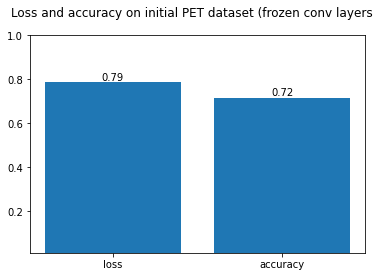

In [ ]:
plt.bar(['loss','accuracy'], metrics)
plt.text('loss', metrics[0], f"{metrics[0]:.2f}", ha='center', va='bottom')
plt.text('accuracy', metrics[1], f"{metrics[1]:.2f}", ha='center', va='bottom')
plt.suptitle("Loss and accuracy on initial PET dataset (frozen conv layers")
plt.ylim(0.01, 1)
plt.show()

## From PET to MRI 1 conv layer unfrozen

In [ ]:
# Testing transfer learning on 3D dataset FROM PET TO MRI with 1 conv layer unfrozen
import pandas as pd
base = DATA_DIR / 'mri/'
res = DATA_DIR / 'pet/'
xtrain = np.load(base / '50-xtrain.npy')
xtest = np.load(base / '50-xtest.npy')
ytrain = np.load(base / '50-ytrain.npy')
ytest = np.load(base / '50-ytest.npy')
pet_img = np.load(res/'50f-xtest.npy')
pet_label = np.load(res/'50-ytest.npy')
tf.keras.backend.clear_session()
hist,metrics,pet_metrics = tuning_3d(xtrain, ytrain, xtest, ytest, pet_img,pet_label, batch_size=4, run_name="pet-transfer-conv1", filename=str(res / f"3d-folds/pet-transfer-conv1.h5"), verbose=0)
val_df = pd.DataFrame(hist.history)
val_df.to_csv(res/'3d-folds/pet-transfer-conv1.csv')

INFO:tensorflow:Assets written to: /tmp/tmpse2qzwtb/model/data/model/assets


2022/04/14 15:29:08 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.2+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


15/15 [==============================] - 1s 45ms/step - loss: 0.4195 - acc: 0.8667
Evaluating on initial MRI dataset
15/15 [==============================] - 1s 45ms/step - loss: 0.4195 - acc: 0.8667


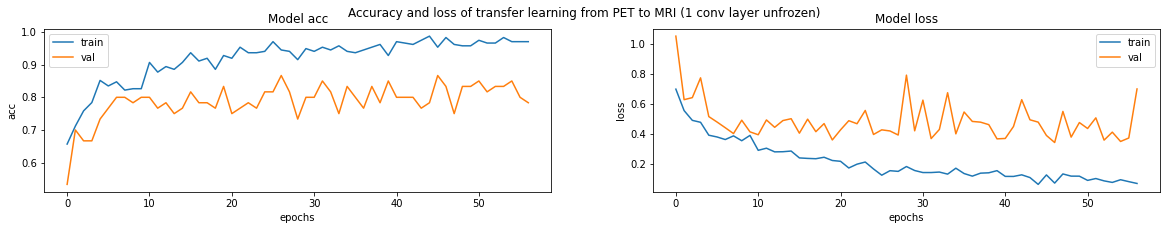

In [ ]:
fig = plot_results(hist)
fig.suptitle("Accuracy and loss of transfer learning from PET to MRI (1 conv layer unfrozen)")
plt.show()

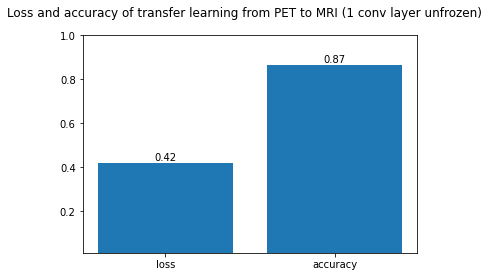

In [ ]:
plt.bar(['loss','accuracy'], metrics)
plt.text('loss', metrics[0], f"{metrics[0]:.2f}", ha='center', va='bottom')
plt.text('accuracy', metrics[1], f"{metrics[1]:.2f}", ha='center', va='bottom')
plt.suptitle("Loss and accuracy of transfer learning from PET to MRI (1 conv layer unfrozen)")
plt.ylim(0.01, 1)
plt.show()

In [ ]:
pet_metrics = metrics

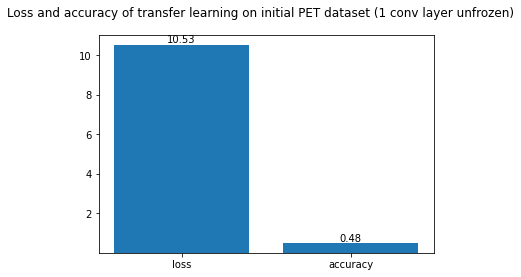

In [ ]:
plt.bar(['loss','accuracy'], pet_metrics)
plt.text('loss', pet_metrics[0], f"{pet_metrics[0]:.2f}", ha='center', va='bottom')
plt.text('accuracy', pet_metrics[1], f"{pet_metrics[1]:.2f}", ha='center', va='bottom')
plt.suptitle("Loss and accuracy of transfer learning on initial PET dataset (1 conv layer unfrozen)")
plt.ylim(0.01, 11)
plt.show()

## From PET to MRI 2 conv layers unfrozen

In [ ]:
# Testing transfer learning on 3D dataset FROM PET TO MRI with 2 conv layer unfrozen
import pandas as pd
base = DATA_DIR / 'mri/'
res = DATA_DIR / 'pet/'
xtrain = np.load(base / '50-xtrain.npy')
xtest = np.load(base / '50-xtest.npy')
ytrain = np.load(base / '50-ytrain.npy')
ytest = np.load(base / '50-ytest.npy')
pet_img = np.load(res/'50f-xtest.npy')
pet_label = np.load(res/'50-ytest.npy')
tf.keras.backend.clear_session()
hist,metrics,pet_metrics = tuning_3d(xtrain, ytrain, xtest, ytest, pet_img,pet_label, batch_size=4, run_name="pet-transfer-conv2", filename=str(res / f"3d-folds/pet-transfer-conv2.h5"), verbose=0)
val_df = pd.DataFrame(hist.history)
val_df.to_csv(res/'3d-folds/pet-transfer-conv2.csv')

INFO:tensorflow:Assets written to: /tmp/tmpev3zmu0t/model/data/model/assets


2022/04/14 15:36:16 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.2+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


15/15 [==============================] - 1s 45ms/step - loss: 0.4126 - acc: 0.8833
Evaluating on initial MRI dataset
15/15 [==============================] - 1s 45ms/step - loss: 0.4126 - acc: 0.8833


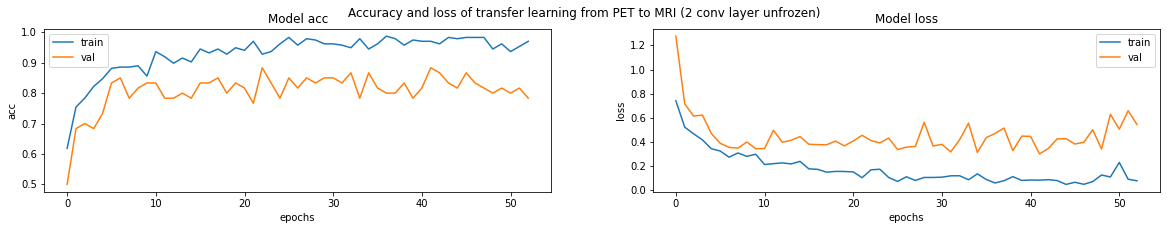

In [ ]:
fig = plot_results(hist)
fig.suptitle("Accuracy and loss of transfer learning from PET to MRI (2 conv layer unfrozen)")
plt.show()

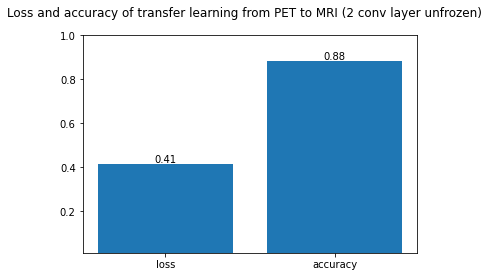

In [ ]:
plt.bar(['loss','accuracy'], metrics)
plt.text('loss', metrics[0], f"{metrics[0]:.2f}", ha='center', va='bottom')
plt.text('accuracy', metrics[1], f"{metrics[1]:.2f}", ha='center', va='bottom')
plt.suptitle("Loss and accuracy of transfer learning from PET to MRI (2 conv layer unfrozen)")
plt.ylim(0.01, 1)
plt.show()

In [ ]:
pet_metrics = metrics

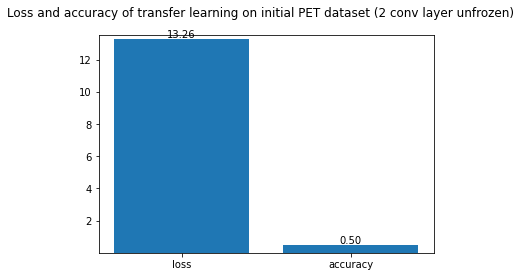

In [ ]:
plt.bar(['loss','accuracy'], pet_metrics)
plt.text('loss', pet_metrics[0], f"{pet_metrics[0]:.2f}", ha='center', va='bottom')
plt.text('accuracy', pet_metrics[1], f"{pet_metrics[1]:.2f}", ha='center', va='bottom')
plt.suptitle("Loss and accuracy of transfer learning on initial PET dataset (2 conv layer unfrozen)")
plt.ylim(0.01, 13.5)
plt.show()

## Testing on two datasets

In [ ]:
model = keras.models.load_model(DATA_DIR / 'pet/3d-folds/pet-transfer.h5')

In [ ]:
model = keras.models.load_model(DATA_DIR / 'pet/3d-folds/pet-transfer.h5')
x_pet = np.load(DATA_DIR/'pet' / '50f-xtest.npy')
x_mri = np.load(DATA_DIR/'mri' / '50-xtest.npy')
y_pet = np.load(DATA_DIR/'pet' / '50-ytest.npy')
y_mri = np.load(DATA_DIR/'mri' / '50-ytest.npy')
pet = tf.data.Dataset.from_tensor_slices((x_pet, y_pet))
mri = tf.data.Dataset.from_tensor_slices((x_mri,y_mri))


pet_val = (
    pet.shuffle(len(x_pet), seed=RANDOM_SEED)
    .batch(4)
    .prefetch(4)
)

mri_val = (
    mri.shuffle(len(x_mri), seed=RANDOM_SEED)
    .batch(4)
    .prefetch(4)
)

In [ ]:
metrics = model.evaluate(pet_val)
metrics

15/15 [==============================] - 1s 75ms/step - loss: 0.7873 - acc: 0.7167


[0.787268340587616, 0.7166666388511658]

In [ ]:
predictions = model.predict(pet_val)
matrix = tf.math.confusion_matrix(y_pet, predictions)
t_n, f_p, t_p, f_n = matrix.numpy().ravel()
print(t_n,f_p,t_p,f_n)

30 0 30 0


In [ ]:
tot = tf.data.Dataset.from_tensor_slices((xte,yte))
t_val = (
    tot.shuffle(len(xte), seed=RANDOM_SEED)
    .batch(4)
    .prefetch(4)
)

predictions = model.predict(t_val)
matrix = tf.math.confusion_matrix(yte, predictions)
t_n, f_p, t_p, f_n = matrix.numpy().ravel()
print(t_n,f_p,t_p,f_n)

58 2 59 1


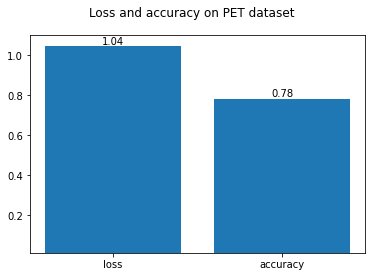

In [ ]:
plt.bar(['loss','accuracy'], metrics)
plt.text('loss', metrics[0], f"{metrics[0]:.2f}", ha='center', va='bottom')
plt.text('accuracy', metrics[1], f"{metrics[1]:.2f}", ha='center', va='bottom')
plt.suptitle("Loss and accuracy on PET dataset")
plt.ylim(0.01, 1.1)
plt.show()

In [ ]:
metrics = model.evaluate(mri_val)
metrics

15/15 [==============================] - 1s 76ms/step - loss: 8.2722 - acc: 0.5000


[8.272247314453125, 0.5]

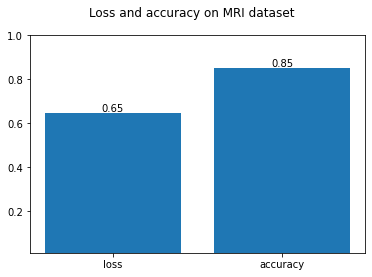

In [ ]:
plt.bar(['loss','accuracy'], metrics)
plt.text('loss', metrics[0], f"{metrics[0]:.2f}", ha='center', va='bottom')
plt.text('accuracy', metrics[1], f"{metrics[1]:.2f}", ha='center', va='bottom')
plt.suptitle("Loss and accuracy on MRI dataset")
plt.ylim(0.01, 1)
plt.show()

Epoch 1/10000
117/117 [==============================] - 45s 258ms/step - loss: 0.6961 - acc: 0.5290 - val_loss: 0.7707 - val_acc: 0.5000
Epoch 2/10000
117/117 [==============================] - 29s 245ms/step - loss: 0.6683 - acc: 0.5978 - val_loss: 0.8968 - val_acc: 0.5000
Epoch 3/10000
117/117 [==============================] - 29s 247ms/step - loss: 0.6432 - acc: 0.6280 - val_loss: 0.8613 - val_acc: 0.5000
Epoch 4/10000
117/117 [==============================] - 29s 249ms/step - loss: 0.6397 - acc: 0.6430 - val_loss: 0.8843 - val_acc: 0.5000
Epoch 5/10000
117/117 [==============================] - 30s 256ms/step - loss: 0.6257 - acc: 0.6753 - val_loss: 0.7339 - val_acc: 0.5500
Epoch 6/10000
117/117 [==============================] - 30s 258ms/step - loss: 0.6282 - acc: 0.6516 - val_loss: 0.6850 - val_acc: 0.5750
Epoch 7/10000
117/117 [==============================] - 30s 260ms/step - loss: 0.6035 - acc: 0.6516 - val_loss: 0.6443 - val_acc: 0.6500
Epoch 8/10000
117/117 [===========

2022/05/19 20:52:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'PrefetchDataset' object has no attribute '_batch_size'


8/8 [==============================] - 2s 132ms/step
tf.Tensor(
[[29  1]
 [ 4 26]], shape=(2, 2), dtype=int32)


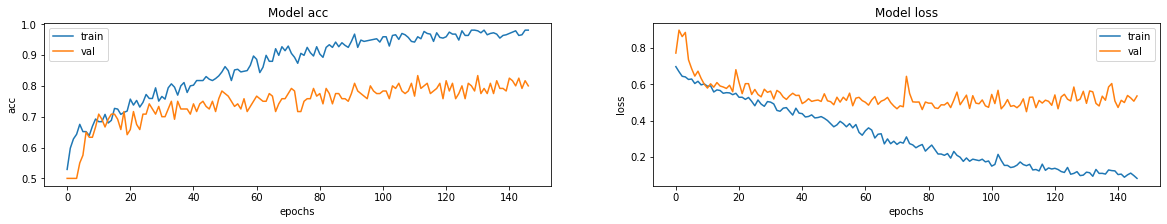

In [ ]:
# New training on both
import pandas as pd
gc.collect()
base = DATA_DIR / 'mri/'
xtrain = np.load(base / '50-xtrain.npy')
xtest = np.load(base / '50-xtest.npy')
ytrain = np.load(base / '50-ytrain.npy')
ytest = np.load(base / '50-ytest.npy')

base = DATA_DIR / 'pet/'
xtrain1 = np.load(base / '50f-xtrain.npy')
xtest1 = np.load(base / '50f-xtest.npy')
ytrain1 = np.load(base / '50-ytrain.npy')
ytest1 = np.load(base / '50-ytest.npy')

xtr = np.concatenate((xtrain,xtrain1),axis=0)
xte = np.concatenate((xtest,xtest1), axis=0)
ytr = np.concatenate((ytrain,ytrain1),axis=0)
yte = np.concatenate((ytest,ytest1), axis=0)

tf.keras.backend.clear_session()
model, metrics,predictions = train_3d_model(xtr, ytr, xte, yte, batch_size=4, run_name="test", filename=str(base / f"folds/validation/test.h5"), verbose=1)
val_df = pd.DataFrame(model.history)
fig = plot_results(model)
val_df.to_csv(base/'3d-folds/test.csv')
plt.show()

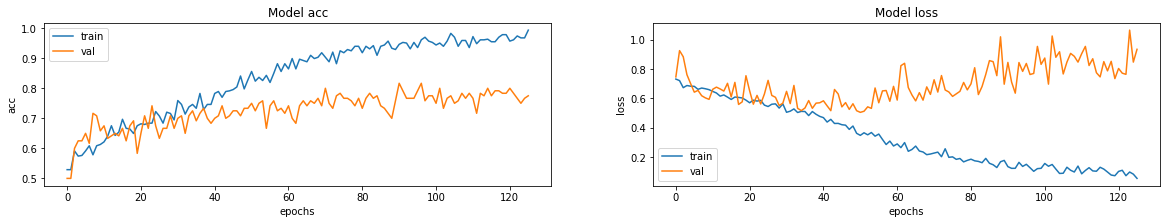

In [ ]:
fig = plot_results(model)
plt.show()

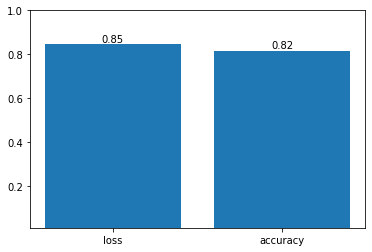

In [ ]:
plt.bar(['loss','accuracy'], metrics)
plt.text('loss', metrics[0], f"{metrics[0]:.2f}", ha='center', va='bottom')
plt.text('accuracy', metrics[1], f"{metrics[1]:.2f}", ha='center', va='bottom')
plt.ylim(0.01, 1)
plt.show()

## 10 Fold on combined model

In [ ]:
from sklearn.model_selection import StratifiedKFold

base = DATA_DIR / 'mri/'
xtrain = np.load(base / '50-xtrain.npy')
#xtest = np.load(base / '50-xtest.npy')
ytrain = np.load(base / '50-ytrain.npy')
#ytest = np.load(base / '50-ytest.npy')

base = DATA_DIR / 'pet/'
xtrain1 = np.load(base / '50f-xtrain.npy')
#xtest1 = np.load(base / '50f-xtest.npy')
ytrain1 = np.load(base / '50-ytrain.npy')
#ytest1 = np.load(base / '50-ytest.npy')

xtr = np.concatenate((xtrain,xtrain1),axis=0)
#xte = np.concatenate((xtest,xtest1), axis=0)
ytr = np.concatenate((ytrain,ytrain1),axis=0)
#yte = np.concatenate((ytest,ytest1), axis=0)

base = DATA_DIR / 'pet/combined'
kFold = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
traintest = kFold.split(xtr,ytr)

for k, (train, test) in enumerate(traintest):
    print('k =',k+1)
    fold_dir = base / f'fold-{k + 1}'
    fold_dir.mkdir(parents=True, exist_ok=True)

    np.save(fold_dir / 'xtrain.npy', xtr[train])
    np.save(fold_dir / 'ytrain.npy', ytr[train])
    np.save(fold_dir / 'xtest.npy', xtr[test])
    np.save(fold_dir / 'ytest.npy', ytr[test])

k = 1
k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
k = 10


In [ ]:
import pandas as pd
batchsize = 4
print("Batchsize:", batchsize)
for k in range(1, 11):
    base = DATA_DIR / f'pet/combined/fold-{k}'
    xtrain = np.load(base / 'xtrain.npy')
    ytrain = np.load(base / 'ytrain.npy')
    xtest = np.load(base / 'xtest.npy')
    ytest = np.load(base / 'ytest.npy')
    tf.keras.backend.clear_session()
    print('k =',k)

    results = DATA_DIR / f'pet/combined/results/fold-{k}'
    results.mkdir(exist_ok=True, parents=True)
    metrics,predictions = train_3d_model(xtrain, ytrain, xtest, ytest, batch_size=batchsize, run_name=f"fold-{k}", filename=str(results / f"combined.h5"), verbose=0)


Batchsize: 4
k = 1
6/6 [==============================] - 1s 83ms/step
tf.Tensor(
[[20  3]
 [ 1 23]], shape=(2, 2), dtype=int32)
k = 2
6/6 [==============================] - 1s 84ms/step
tf.Tensor(
[[21  2]
 [ 5 19]], shape=(2, 2), dtype=int32)
k = 3
6/6 [==============================] - 1s 83ms/step
tf.Tensor(
[[17  6]
 [ 5 19]], shape=(2, 2), dtype=int32)
k = 4
6/6 [==============================] - 1s 83ms/step
tf.Tensor(
[[20  4]
 [ 7 16]], shape=(2, 2), dtype=int32)
k = 5
6/6 [==============================] - 1s 83ms/step
tf.Tensor(
[[17  7]
 [ 4 19]], shape=(2, 2), dtype=int32)
k = 6
6/6 [==============================] - 1s 89ms/step
tf.Tensor(
[[23  0]
 [ 4 19]], shape=(2, 2), dtype=int32)
k = 7
6/6 [==============================] - 1s 82ms/step
tf.Tensor(
[[21  2]
 [ 4 19]], shape=(2, 2), dtype=int32)
k = 8
6/6 [==============================] - 1s 84ms/step
tf.Tensor(
[[17  6]
 [ 3 20]], shape=(2, 2), dtype=int32)
k = 9
6/6 [==============================] - 1s 83ms/step
t

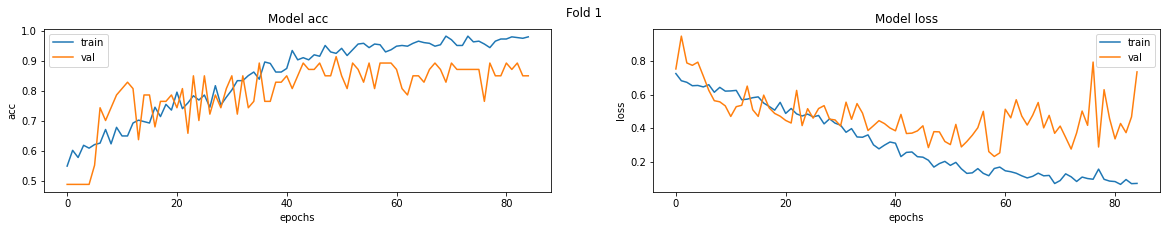

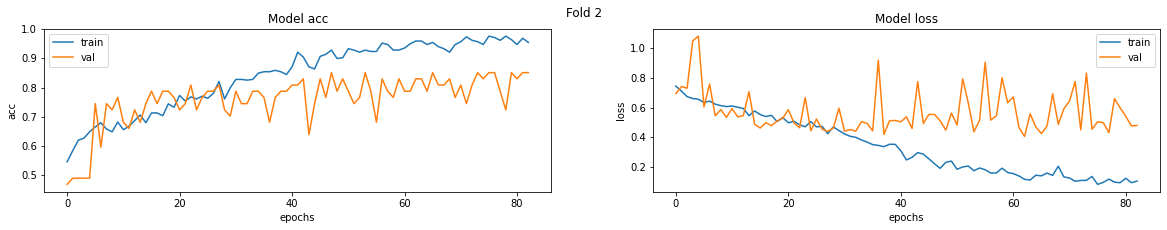

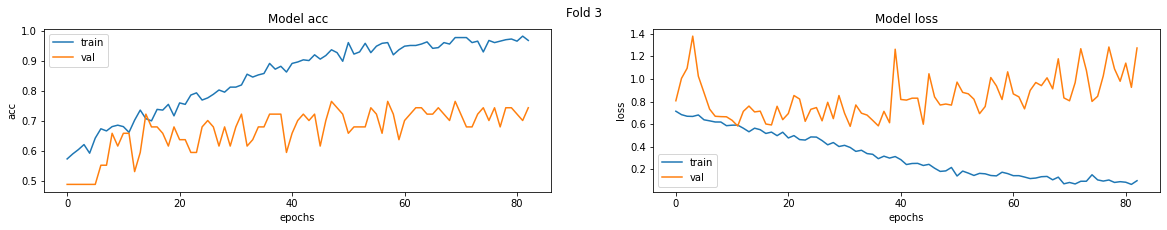

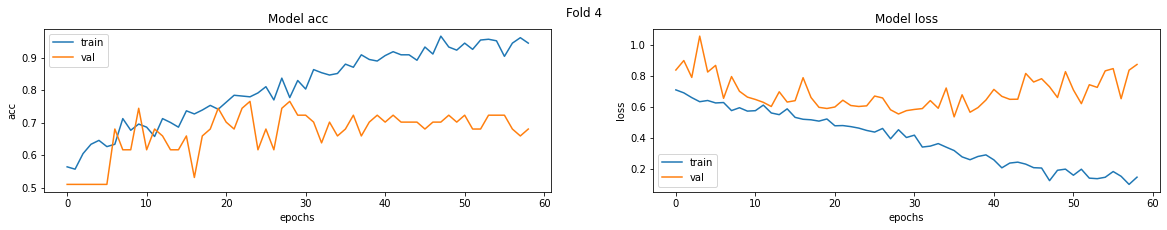

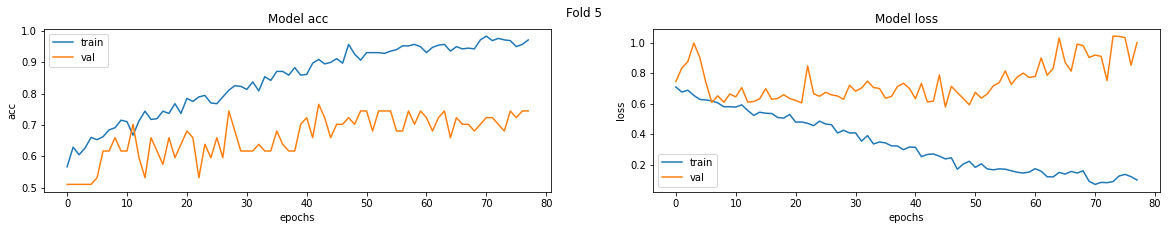

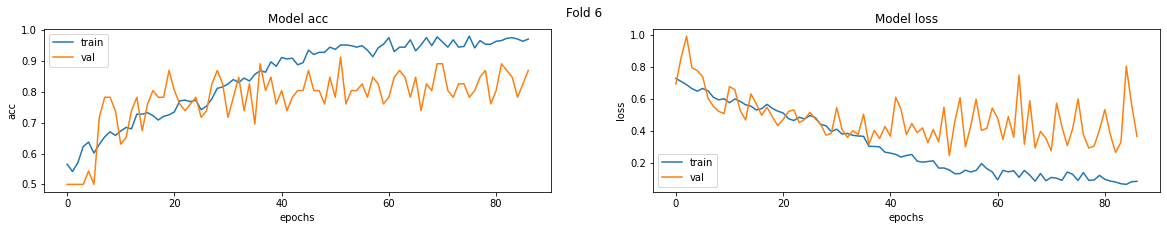

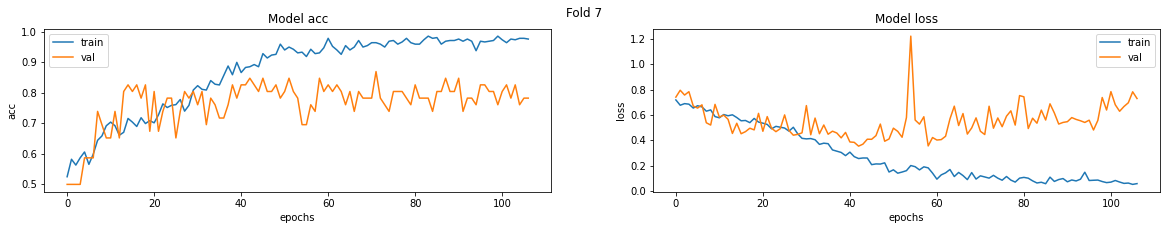

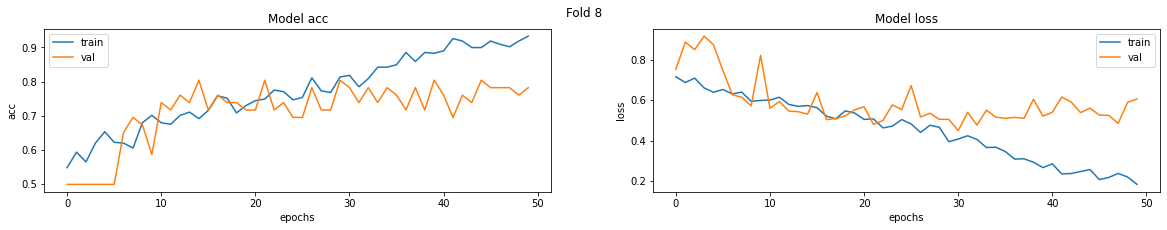

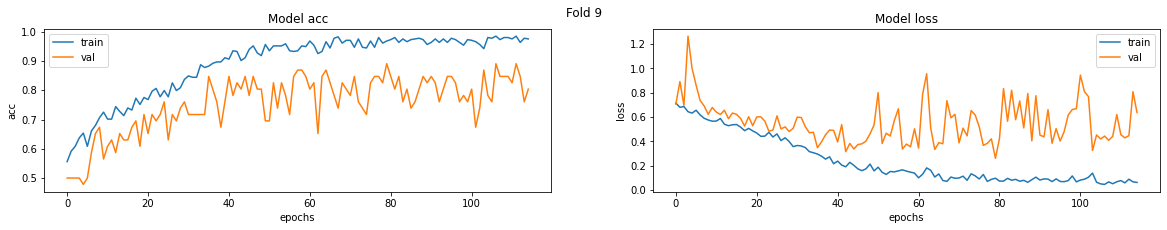

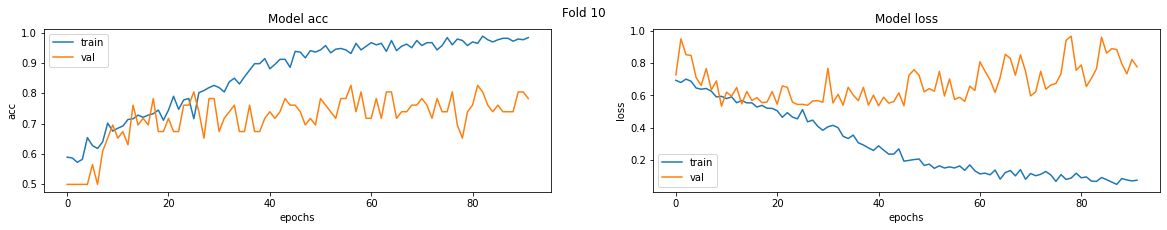

In [ ]:
def plot_folds(history):
  fig, ax = plt.subplots(1, 2, figsize=(20, 3))
  ax = ax.ravel()
  for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(history[metric])
    ax[i].plot(history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
  return fig


history = []
for i in range(1,11):
  x = pd.read_csv(DATA_DIR / f'pet/combined/results/fold-{i}'/f'{i}-history.csv')
  history.append(x)

for i,history in enumerate(history):
  fig = plot_folds(history)
  fig.suptitle(f"Fold {i+1}")

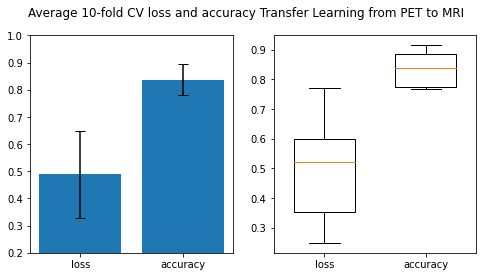

In [ ]:
metrics_in_time = np.array(m)
fig, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].bar(['loss', 'accuracy'], np.mean(metrics_in_time, axis=0), yerr=np.std(metrics_in_time, axis=0), error_kw={'capsize': 5})
ax[0].set_ylim(0.2,1 )
ax[1].boxplot(metrics_in_time, labels=['loss', 'accuracy'], widths=[0.6,0.6])
fig.suptitle("Average 10-fold CV loss and accuracy Transfer Learning from PET to MRI")
plt.show()

In [ ]:
f = open(DATA_DIR / f'pet/combined/results/combined.metrics.txt','w')
f.writelines(str(m))
f.close()

## Merged model

In [ ]:
def get_3d_x(name, width=128, height=128, depth=50):
    """Build a convolutional neural network model based on the Zunhair et al model.
    References
    ----------
    - https://arxiv.org/abs/2007.13224
    """
    inputs = keras.Input((width, height, depth, 1), name='input_x')

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", trainable=False)(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization(trainable=False)(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", trainable=False)(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization(trainable=False)(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu", trainable=False)(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization(trainable=False)(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu", trainable=False)(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization(trainable=False)(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu", trainable=False)(x)
    x = layers.Dropout(0.3, name="drop_x")(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name=name)
    return model

In [ ]:
def get_3d_y(name, width=128, height=128, depth=50):
    """Build a convolutional neural network model based on the Zunhair et al model.
    References
    ----------
    - https://arxiv.org/abs/2007.13224
    """
    inputs = keras.Input((width, height, depth, 1), name='input_y')

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu",trainable=False)(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization(trainable=False)(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu",trainable=False)(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization(trainable=False)(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu",trainable=False)(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization(trainable=False)(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu",trainable=False)(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization(trainable=False)(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu", trainable=False)(x)
    x = layers.Dropout(0.3, name="drop_y")(x)

    outputs = layers.Dense(units=1, activation="sigmoid" , name="out_y")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name=name)
    return model

In [ ]:
from keras.layers import *
from keras.models import Sequential, Model

def get_merged():
  mri_model = get_3d_model()
  pet_model = get_3d_model()
  mri_model.load_weights(DATA_DIR/'mri/folds/validation/50-mri.h5')
  pet_model.load_weights(DATA_DIR/'pet/folds/validation/50-pet.h5')
  mri_model = Model(inputs=mri_model.input, outputs=mri_model.layers[-3].output)
  pet_model = Model(inputs=pet_model.input, outputs=pet_model.layers[-3].output)
  merged = concatenate([mri_model.output,pet_model.output])
  z = Dense(128, activation='relu')(merged)
  z = layers.Dropout(0.3)(z)
  z = Dense(1, activation='sigmoid')(z)
  merged_model = Model(inputs=[mri_model.input,pet_model.input], outputs=z)
  return merged_model

In [ ]:
from keras.layers import *
from keras.models import Sequential, Model

def get_merged():
  mri_model = get_3d_x("mri")
  pet_model = get_3d_y("pet")
  mri_model.load_weights(DATA_DIR/'mri/folds/validation/50-mri.h5')
  pet_model.load_weights(DATA_DIR/'pet/folds/validation/50-pet.h5')
  mri_model = Model(inputs=mri_model.input, outputs=mri_model.layers[-3].output)
  pet_model = Model(inputs=pet_model.input, outputs=pet_model.layers[-3].output)
  merged = concatenate([mri_model.output,pet_model.output])
  z = Dense(4, activation='relu')(merged)
  z = layers.Dropout(0.3)(merged)
  z = Dense(1, activation='sigmoid')(z)
  merged_model = Model(inputs=[mri_model.input,pet_model.input], outputs=z)
  return merged_model

In [ ]:
def get_dataset(d,d1,l):
  d_set = tf.data.Dataset.from_tensor_slices(d)
  d1_set = tf.data.Dataset.from_tensor_slices(d1)
  l_set = tf.data.Dataset.from_tensor_slices(l)
  dataset = tf.data.Dataset.zip(((d_set,d1_set),l_set))
  dataset = dataset.batch(4).prefetch(4)
  return dataset

In [ ]:
def get_dataset(d,d1):
  d_set = tf.data.Dataset.from_tensor_slices((d,d1))
  dataset = d_set.batch(4).prefetch(4)
  return dataset

In [ ]:
# Compile model.
def train_merged(xtrain, xtrain1, ytrain1, xtest, ytest, xtest1, ytest1, epochs=10000, verbose=2, batch_size=32, run_name="run", filename="3d_image_classification.h5"):
    # Build model.
    mlflow.tensorflow.autolog()
    with mlflow.start_run(run_name=run_name):
        model = get_merged()

        training_set = get_dataset(xtrain,xtrain1,ytrain1)
        validation_set = get_dataset(xtest,xtest1,ytest)
    
        initial_learning_rate = 5e-5    # from https://doi.org/10.3938/jkps.75.597
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
        )
        model.compile(
            loss="binary_crossentropy",
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            metrics=['acc']
        )

        # Define callbacks.
        checkpoint_cb = keras.callbacks.ModelCheckpoint(
            filename, monitor="val_acc", save_best_only=True
        )
        early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=35, min_delta=0.001, baseline=0.60, restore_best_weights=True)
        # Train the model, doing validation at the end of each epoch
        history = model.fit(
            training_set,
            validation_data = validation_set,
            epochs=epochs,
            shuffle=True,
            verbose=verbose,
            callbacks=[checkpoint_cb, early_stopping_cb],
        )
        tf.keras.backend.clear_session()
        #mlflow.log_artifacts(str(Path(filename).parent))

        model.load_weights(filename)
        metrics = model.evaluate(validation_set)
        mlflow.log_metric("val_loss", metrics[0])
        mlflow.log_metric("val_accuracy", metrics[1])
        predictions = model.predict([xtest,xtest1], batch_size=8, verbose=1)
        t_n, f_p, f_n, t_p = get_matrix(predictions,ytest)
        pred = [t_n,f_p,f_n,t_p]
        mlflow.log_metric("confusion.tn", t_n)
        mlflow.log_metric("confusion.fp", f_p)
        mlflow.log_metric("confusion.fn", f_n)
        mlflow.log_metric("confusion.tp", t_p)
        
        #metrics = model.predict(validation_dataset)

    return history, metrics, pred

In [ ]:
from keras.layers import *
from keras.models import Sequential, Model

def get_merged_cv(i):
  mri_model = get_3d_x("mri")
  pet_model = get_3d_y("pet")
  #mri_model =  tf.keras.models.load_model(DATA_DIR/f'mri/3d-folds/50/results/fold-{i}/50-mri.h5')
  mri_model.load_weights(DATA_DIR/f'mri/3d-folds/50/results/fold-{i}/50-mri.h5')
  #pet_model = tf.keras.models.load_model(DATA_DIR/f'pet/3d-folds/50/results/fold-{i}/memento-pet.h5')
  mri_model.load_weights(DATA_DIR/f'pet/3d-folds/50/results/fold-{i}/memento-pet.h5')
  mri_model = Model(inputs=mri_model.input, outputs=mri_model.layers[-3].output)
  pet_model = Model(inputs=pet_model.input, outputs=pet_model.layers[-3].output)
  merged = concatenate([mri_model.output,pet_model.output])
  z = Dense(8, activation='relu')(merged)
  z = layers.Dropout(0.3)(z)
  z = Dense(1, activation='sigmoid')(z)
  merged_model = Model(inputs=[mri_model.input,pet_model.input], outputs=z)
  return merged_model

In [ ]:
# Compile model.
def train_merged_cv(i, xtrain, xtrain1, ytrain1, xtest, ytest, xtest1, ytest1, epochs=10000, verbose=2, batch_size=32, run_name="run", filename="3d_image_classification.h5"):
    # Build model.
    mlflow.tensorflow.autolog()
    with mlflow.start_run(run_name=run_name):
        model = get_merged_cv(i)

        training_set = get_dataset(xtrain,xtrain1,ytrain1)
        validation_set = get_dataset(xtest,xtest1,ytest1)
    
        initial_learning_rate = 5e-5    # from https://doi.org/10.3938/jkps.75.597
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
        )
        model.compile(
            loss="binary_crossentropy",
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            metrics=['acc']
        )

        # Define callbacks.
        checkpoint_cb = keras.callbacks.ModelCheckpoint(
            filename, monitor="val_acc", save_best_only=True
        )
        early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=40, min_delta=0.001, baseline=0.60, restore_best_weights=True)
        # Train the model, doing validation at the end of each epoch
        history = model.fit(
            training_set,
            validation_data = validation_set,
            epochs=epochs,
            shuffle=True,
            verbose=verbose,
            callbacks=[checkpoint_cb, early_stopping_cb],
        )
        tf.keras.backend.clear_session()
        #mlflow.log_artifacts(str(Path(filename).parent))

        model.load_weights(filename)
        metrics = model.evaluate(validation_set)
        mlflow.log_metric("val_loss", metrics[0])
        mlflow.log_metric("val_accuracy", metrics[1])
        predictions = model.predict(validation_set)
        scores = np.array([[1-p, p] for p in predictions[:,0]])
        mat = confusion_matrix(ytest, np.argmax(scores, axis=1))
        #np.save(folder / 'confusion-matrix.npy', mat)
        t_n, f_p, f_n, t_p = get_matrix(predictions,ytest)
        pred = [t_n,f_p,f_n,t_p]
        mlflow.log_metric("confusion.tn", t_n)
        mlflow.log_metric("confusion.fp", f_p)
        mlflow.log_metric("confusion.fn", f_n)
        mlflow.log_metric("confusion.tp", t_p)

        mlflow.log_metric("sensitivity", sensitivity(mat))
        mlflow.log_metric("specificity", specificity(mat))
        mlflow.log_metric("auc", roc_auc_score(ytest, predictions[:,0]))
        
        #metrics = model.predict(validation_dataset)

    return history, metrics, pred

Epoch 1/10000
58/58 - 26s - loss: 0.6932 - acc: 0.6026 - val_loss: 0.6483 - val_acc: 0.6000 - 26s/epoch - 452ms/step
Epoch 2/10000
58/58 - 12s - loss: 0.6294 - acc: 0.6463 - val_loss: 0.6076 - val_acc: 0.6333 - 12s/epoch - 201ms/step
Epoch 3/10000
58/58 - 12s - loss: 0.5564 - acc: 0.7511 - val_loss: 0.5723 - val_acc: 0.6833 - 12s/epoch - 203ms/step
Epoch 4/10000
58/58 - 12s - loss: 0.4912 - acc: 0.8297 - val_loss: 0.5412 - val_acc: 0.8167 - 12s/epoch - 203ms/step
Epoch 5/10000
58/58 - 12s - loss: 0.4403 - acc: 0.8908 - val_loss: 0.5146 - val_acc: 0.8500 - 12s/epoch - 204ms/step
Epoch 6/10000
58/58 - 12s - loss: 0.4026 - acc: 0.9170 - val_loss: 0.4906 - val_acc: 0.8833 - 12s/epoch - 206ms/step
Epoch 7/10000
58/58 - 13s - loss: 0.3724 - acc: 0.9607 - val_loss: 0.4694 - val_acc: 0.9167 - 13s/epoch - 221ms/step
Epoch 8/10000
58/58 - 12s - loss: 0.3374 - acc: 0.9651 - val_loss: 0.4510 - val_acc: 0.9500 - 12s/epoch - 207ms/step
Epoch 9/10000
58/58 - 12s - loss: 0.3059 - acc: 0.9651 - val_los

2022/05/19 16:48:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'PrefetchDataset' object has no attribute '_batch_size'


8/8 [==============================] - 4s 267ms/step
tf.Tensor(
[[29  1]
 [ 2 28]], shape=(2, 2), dtype=int32)


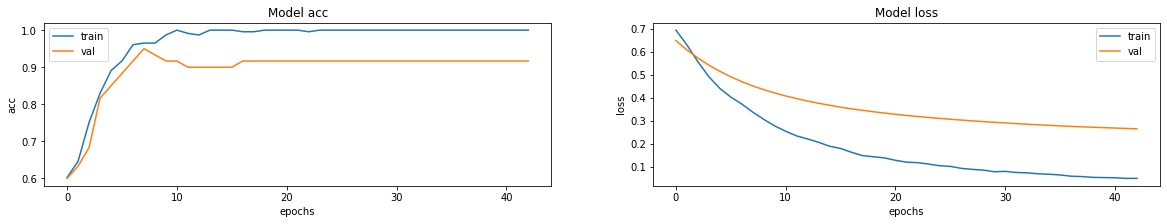

In [ ]:
import gc
gc.collect()
base = DATA_DIR / 'mri/'
xtrain = np.load(base / '50-xtrain.npy')
#xtest = np.load(base / '50-xtest.npy')
#ytrain = np.load(base / '50-ytrain.npy')
#ytest = np.load(base / '50-ytest.npy')
xtrain = np.delete(xtrain,[55,73,80,150,180,193,203],axis=0)

base = DATA_DIR / 'pet/'
xtrain1 = np.load(base / '50f-xtrain.npy')
#xtest1 = np.load(base / '50f-xtest.npy')
ytrain1 = np.load(base / '50-ytrain.npy')
#ytest1 = np.load(base / '50-ytest.npy')

base = DATA_DIR / 'mri/'
xtest = np.load(base / '50-xtest.npy')
#xtest = np.load(base / '50-xtest.npy')
ytest = np.load(base / '50-ytest.npy')
#ytest = np.load(base / '50-ytest.npy')

base = DATA_DIR / 'pet/'
xtest1 = np.load(base / '50f-xtest.npy')
#xtest1 = np.load(base / '50f-xtest.npy')
ytest1 = np.load(base / '50-ytest.npy')
#ytest1 = np.load(base / '50-ytest.npy')
#tf.keras.backend.clear_session()

results = DATA_DIR / f'pet/combined/results/'
results.mkdir(exist_ok=True, parents=True)
history, metrics,predictions = train_merged(xtrain, xtrain1, ytrain1, xtest, ytest, xtest1, ytest1, batch_size=6, run_name="merged", filename=str(results / "merged-final.h5"), verbose=2)
fig = plot_results(history)
plt.show()

In [ ]:
path = DATA_DIR / 'pet/combined/results/merged-freezed.h5'
model = new_model = tf.keras.models.load_model(path)
base = DATA_DIR / 'mri/'
xtest = np.load(base / '50-xtest.npy')
#xtest = np.load(base / '50-xtest.npy')
ytest = np.load(base / '50-ytest.npy')
#ytest = np.load(base / '50-ytest.npy')

base = DATA_DIR / 'pet/'
xtest1 = np.load(base / '50f-xtest.npy')
#xtest1 = np.load(base / '50f-xtest.npy')
ytest1 = np.load(base / '50-ytest.npy')
#ytest1 = np.load(base / '50-ytest.npy')
tf.keras.backend.clear_session()
test = get_dataset(xtest,xtest1,ytest)

a = model.evaluate(test)
print(a)
predictions = model.predict(test)
scores = np.array([[1-p, p] for p in predictions[:,0]])
mat = confusion_matrix(ytest, np.argmax(scores, axis=1))
#np.save(folder / 'confusion-matrix.npy', mat)
print(mat)
results += [(sensitivity(mat), specificity(mat), roc_auc_score(ytest, predictions))]
print(results)

r = model.predict(test)
r = tf.greater(r,0.5)
p = np.array([1 if x  else 0 for x in r])
matrix = tf.math.confusion_matrix(ytest, p)
a = matrix.numpy().ravel()
print(a)

15/15 [==============================] - 9s 515ms/step - loss: 0.4804 - acc: 0.9500
[0.4804410934448242, 0.949999988079071]
[[29  1]
 [ 2 28]]
[(0.9333333333333333, 0.9666666666666667, 0.9333333333333333)]
[29  1  2 28]


In [ ]:
model.evaluate(test)

15/15 [==============================] - 7s 424ms/step - loss: 0.4804 - acc: 0.9500


[0.4804410934448242, 0.949999988079071]

In [ ]:
def get_matrix(m,y):
  m = tf.greater(m,0.5)
  p = np.array([1 if x else 0 for x in m])
  matrix = tf.math.confusion_matrix(y,p)
  print(matrix)
  return matrix.numpy().ravel()

In [ ]:
import numpy as np
base = DATA_DIR / 'mri/'
xtrain = np.load(base / '50-xtrain.npy')
xtest = np.load(base/ '50-xtest.npy')
print(xtrain.shape,xtest.shape)

(236, 128, 128, 50) (60, 128, 128, 50)


# CV on merged model

Batchsize: 5
k = 4
Epoch 1/10000
52/52 - 27s - loss: 0.6939 - acc: 0.5728 - val_loss: 0.6672 - val_acc: 0.6522 - 27s/epoch - 512ms/step
Epoch 2/10000
52/52 - 23s - loss: 0.6626 - acc: 0.6456 - val_loss: 0.6503 - val_acc: 0.6957 - 23s/epoch - 450ms/step
Epoch 3/10000
52/52 - 23s - loss: 0.6461 - acc: 0.6845 - val_loss: 0.6347 - val_acc: 0.7391 - 23s/epoch - 441ms/step
Epoch 4/10000
52/52 - 23s - loss: 0.6084 - acc: 0.8155 - val_loss: 0.6169 - val_acc: 0.8261 - 23s/epoch - 445ms/step
Epoch 5/10000
52/52 - 23s - loss: 0.5920 - acc: 0.8010 - val_loss: 0.6025 - val_acc: 0.8261 - 23s/epoch - 435ms/step
Epoch 6/10000
52/52 - 23s - loss: 0.5549 - acc: 0.8592 - val_loss: 0.5893 - val_acc: 0.8261 - 23s/epoch - 434ms/step
Epoch 7/10000
52/52 - 23s - loss: 0.5580 - acc: 0.8495 - val_loss: 0.5776 - val_acc: 0.9130 - 23s/epoch - 441ms/step
Epoch 8/10000
52/52 - 23s - loss: 0.5201 - acc: 0.8835 - val_loss: 0.5668 - val_acc: 0.8696 - 23s/epoch - 434ms/step
Epoch 9/10000
52/52 - 22s - loss: 0.4871 - ac

2022/05/18 17:31:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'PrefetchDataset' object has no attribute '_batch_size'


6/6 [==============================] - 3s 375ms/step - loss: 0.5776 - acc: 0.9130
tf.Tensor(
[[10  1]
 [ 1 11]], shape=(2, 2), dtype=int32)
[10, 1, 1, 11]
k = 5
Epoch 1/10000
52/52 - 24s - loss: 0.6852 - acc: 0.5485 - val_loss: 0.6631 - val_acc: 0.6522 - 24s/epoch - 471ms/step
Epoch 2/10000
52/52 - 22s - loss: 0.6269 - acc: 0.7184 - val_loss: 0.6343 - val_acc: 0.6522 - 22s/epoch - 432ms/step
Epoch 3/10000
52/52 - 23s - loss: 0.5998 - acc: 0.7330 - val_loss: 0.6086 - val_acc: 0.7826 - 23s/epoch - 444ms/step
Epoch 4/10000
52/52 - 23s - loss: 0.5532 - acc: 0.8301 - val_loss: 0.5850 - val_acc: 0.7826 - 23s/epoch - 435ms/step
Epoch 5/10000
52/52 - 22s - loss: 0.5138 - acc: 0.8932 - val_loss: 0.5622 - val_acc: 0.7826 - 22s/epoch - 433ms/step
Epoch 6/10000
52/52 - 23s - loss: 0.4818 - acc: 0.8786 - val_loss: 0.5399 - val_acc: 0.8261 - 23s/epoch - 442ms/step
Epoch 7/10000
52/52 - 22s - loss: 0.4712 - acc: 0.9126 - val_loss: 0.5198 - val_acc: 0.8261 - 22s/epoch - 431ms/step
Epoch 8/10000
52/52 

2022/05/18 17:54:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'PrefetchDataset' object has no attribute '_batch_size'


6/6 [==============================] - 3s 374ms/step - loss: 0.5399 - acc: 0.8261
tf.Tensor(
[[ 9  2]
 [ 2 10]], shape=(2, 2), dtype=int32)
[9, 2, 2, 10]
k = 6
Epoch 1/10000
52/52 - 24s - loss: 0.6631 - acc: 0.6165 - val_loss: 0.6565 - val_acc: 0.5652 - 24s/epoch - 470ms/step
Epoch 2/10000
52/52 - 23s - loss: 0.6091 - acc: 0.7379 - val_loss: 0.6267 - val_acc: 0.8261 - 23s/epoch - 445ms/step
Epoch 3/10000
52/52 - 23s - loss: 0.5490 - acc: 0.8398 - val_loss: 0.5886 - val_acc: 0.9130 - 23s/epoch - 444ms/step
Epoch 4/10000
52/52 - 22s - loss: 0.4911 - acc: 0.9126 - val_loss: 0.5510 - val_acc: 0.9130 - 22s/epoch - 432ms/step
Epoch 5/10000
52/52 - 23s - loss: 0.4347 - acc: 0.9612 - val_loss: 0.5122 - val_acc: 0.9130 - 23s/epoch - 433ms/step
Epoch 6/10000
52/52 - 23s - loss: 0.3816 - acc: 0.9612 - val_loss: 0.4774 - val_acc: 0.9565 - 23s/epoch - 443ms/step
Epoch 7/10000
52/52 - 23s - loss: 0.3289 - acc: 0.9854 - val_loss: 0.4499 - val_acc: 0.9565 - 23s/epoch - 433ms/step
Epoch 8/10000
52/52 -

2022/05/18 18:16:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'PrefetchDataset' object has no attribute '_batch_size'


6/6 [==============================] - 3s 371ms/step - loss: 0.4774 - acc: 0.9565
tf.Tensor(
[[12  0]
 [ 1 10]], shape=(2, 2), dtype=int32)
[12, 0, 1, 10]
k = 7
Epoch 1/10000
52/52 - 25s - loss: 0.7013 - acc: 0.5534 - val_loss: 0.6398 - val_acc: 0.7826 - 25s/epoch - 472ms/step
Epoch 2/10000
52/52 - 23s - loss: 0.6117 - acc: 0.6990 - val_loss: 0.6079 - val_acc: 0.9130 - 23s/epoch - 445ms/step
Epoch 3/10000
52/52 - 22s - loss: 0.5579 - acc: 0.8155 - val_loss: 0.5782 - val_acc: 0.9130 - 22s/epoch - 433ms/step
Epoch 4/10000
52/52 - 23s - loss: 0.5347 - acc: 0.7767 - val_loss: 0.5520 - val_acc: 0.9565 - 23s/epoch - 443ms/step
Epoch 5/10000
52/52 - 23s - loss: 0.4986 - acc: 0.8204 - val_loss: 0.5294 - val_acc: 0.9565 - 23s/epoch - 434ms/step
Epoch 6/10000
52/52 - 23s - loss: 0.4552 - acc: 0.8738 - val_loss: 0.5027 - val_acc: 0.9565 - 23s/epoch - 435ms/step
Epoch 7/10000
52/52 - 22s - loss: 0.4186 - acc: 0.8883 - val_loss: 0.4805 - val_acc: 0.9565 - 22s/epoch - 432ms/step
Epoch 8/10000
52/52 

2022/05/18 18:37:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'PrefetchDataset' object has no attribute '_batch_size'


6/6 [==============================] - 3s 375ms/step - loss: 0.5520 - acc: 0.9565
tf.Tensor(
[[12  0]
 [ 1 10]], shape=(2, 2), dtype=int32)
[12, 0, 1, 10]
k = 8
Epoch 1/10000
52/52 - 25s - loss: 0.7399 - acc: 0.4563 - val_loss: 0.7095 - val_acc: 0.3913 - 25s/epoch - 472ms/step
Epoch 2/10000
52/52 - 23s - loss: 0.7308 - acc: 0.4757 - val_loss: 0.7047 - val_acc: 0.4348 - 23s/epoch - 443ms/step
Epoch 3/10000
52/52 - 23s - loss: 0.6864 - acc: 0.5437 - val_loss: 0.6967 - val_acc: 0.4348 - 23s/epoch - 436ms/step
Epoch 4/10000
52/52 - 23s - loss: 0.6816 - acc: 0.5534 - val_loss: 0.6907 - val_acc: 0.4783 - 23s/epoch - 445ms/step
Epoch 5/10000
52/52 - 23s - loss: 0.6377 - acc: 0.6262 - val_loss: 0.6843 - val_acc: 0.4783 - 23s/epoch - 435ms/step
Epoch 6/10000
52/52 - 23s - loss: 0.6404 - acc: 0.5777 - val_loss: 0.6787 - val_acc: 0.5217 - 23s/epoch - 442ms/step
Epoch 7/10000
52/52 - 23s - loss: 0.6016 - acc: 0.6893 - val_loss: 0.6733 - val_acc: 0.5652 - 23s/epoch - 442ms/step
Epoch 8/10000
52/52 

2022/05/18 19:06:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'PrefetchDataset' object has no attribute '_batch_size'


6/6 [==============================] - 3s 370ms/step - loss: 0.6362 - acc: 0.6087
tf.Tensor(
[[10  2]
 [ 7  4]], shape=(2, 2), dtype=int32)
[10, 2, 7, 4]
k = 9
Epoch 1/10000
52/52 - 25s - loss: 0.7309 - acc: 0.3981 - val_loss: 0.7157 - val_acc: 0.4348 - 25s/epoch - 471ms/step
Epoch 2/10000
52/52 - 22s - loss: 0.7061 - acc: 0.5243 - val_loss: 0.7045 - val_acc: 0.4348 - 22s/epoch - 432ms/step
Epoch 3/10000
52/52 - 23s - loss: 0.6860 - acc: 0.6262 - val_loss: 0.6963 - val_acc: 0.4783 - 23s/epoch - 443ms/step
Epoch 4/10000
52/52 - 23s - loss: 0.6712 - acc: 0.7136 - val_loss: 0.6891 - val_acc: 0.5217 - 23s/epoch - 444ms/step
Epoch 5/10000
52/52 - 23s - loss: 0.6541 - acc: 0.8252 - val_loss: 0.6810 - val_acc: 0.5652 - 23s/epoch - 446ms/step
Epoch 6/10000
52/52 - 22s - loss: 0.6451 - acc: 0.8204 - val_loss: 0.6700 - val_acc: 0.5652 - 22s/epoch - 433ms/step
Epoch 7/10000
52/52 - 23s - loss: 0.6275 - acc: 0.8398 - val_loss: 0.6561 - val_acc: 0.6087 - 23s/epoch - 443ms/step
Epoch 8/10000
52/52 -

2022/05/18 19:32:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'PrefetchDataset' object has no attribute '_batch_size'


6/6 [==============================] - 3s 371ms/step - loss: 0.5716 - acc: 0.8261
tf.Tensor(
[[ 9  3]
 [ 1 10]], shape=(2, 2), dtype=int32)
[9, 3, 1, 10]
k = 10
Epoch 1/10000
52/52 - 25s - loss: 0.6965 - acc: 0.5169 - val_loss: 0.6779 - val_acc: 0.5000 - 25s/epoch - 473ms/step
Epoch 2/10000
52/52 - 23s - loss: 0.6525 - acc: 0.5845 - val_loss: 0.6553 - val_acc: 0.5455 - 23s/epoch - 441ms/step
Epoch 3/10000
52/52 - 23s - loss: 0.6188 - acc: 0.6473 - val_loss: 0.6382 - val_acc: 0.6364 - 23s/epoch - 447ms/step
Epoch 4/10000
52/52 - 23s - loss: 0.5835 - acc: 0.6957 - val_loss: 0.6235 - val_acc: 0.6364 - 23s/epoch - 435ms/step
Epoch 5/10000
52/52 - 22s - loss: 0.5481 - acc: 0.7826 - val_loss: 0.6041 - val_acc: 0.6364 - 22s/epoch - 433ms/step
Epoch 6/10000
52/52 - 23s - loss: 0.5095 - acc: 0.8406 - val_loss: 0.5811 - val_acc: 0.7273 - 23s/epoch - 442ms/step
Epoch 7/10000
52/52 - 22s - loss: 0.4660 - acc: 0.8986 - val_loss: 0.5647 - val_acc: 0.7273 - 22s/epoch - 432ms/step
Epoch 8/10000
52/52 

2022/05/18 19:55:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'PrefetchDataset' object has no attribute '_batch_size'


6/6 [==============================] - 3s 351ms/step - loss: 0.5427 - acc: 0.8182
tf.Tensor(
[[ 8  3]
 [ 1 10]], shape=(2, 2), dtype=int32)
[8, 3, 1, 10]


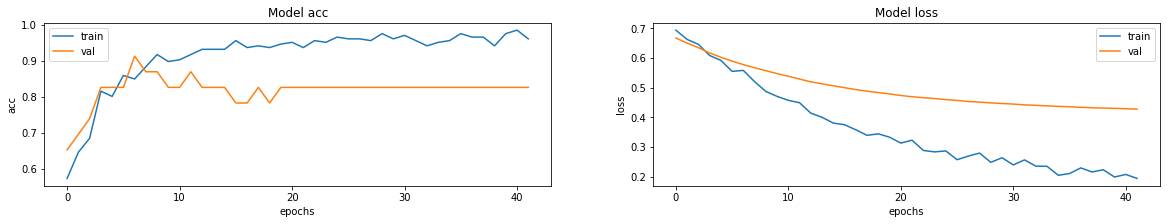

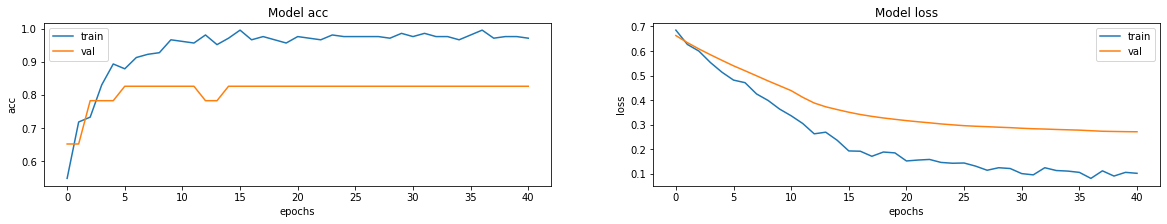

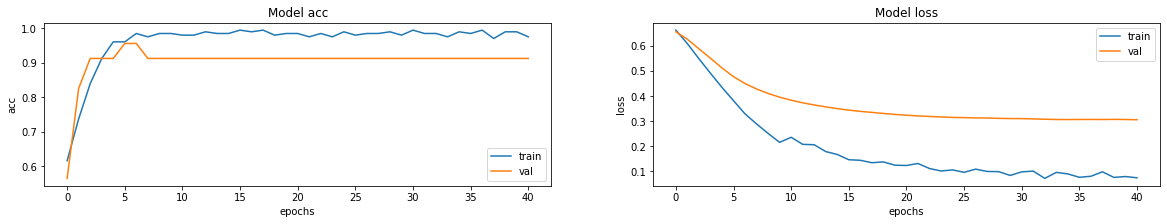

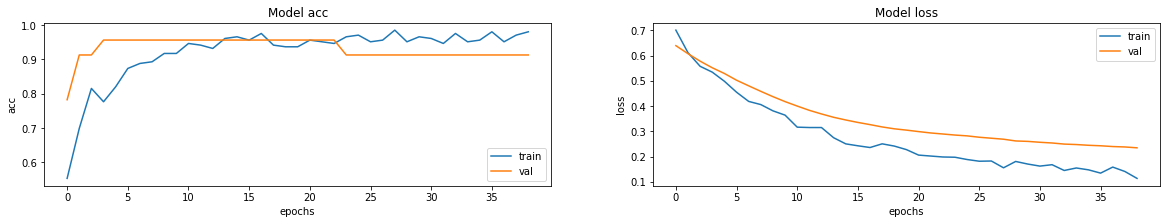

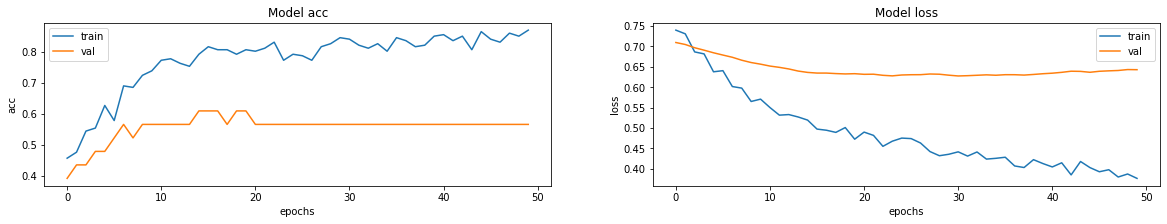

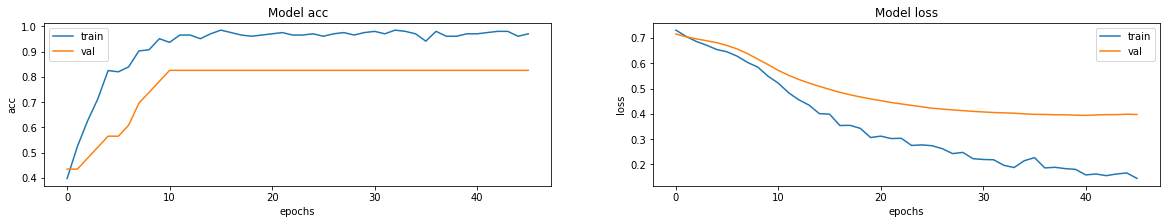

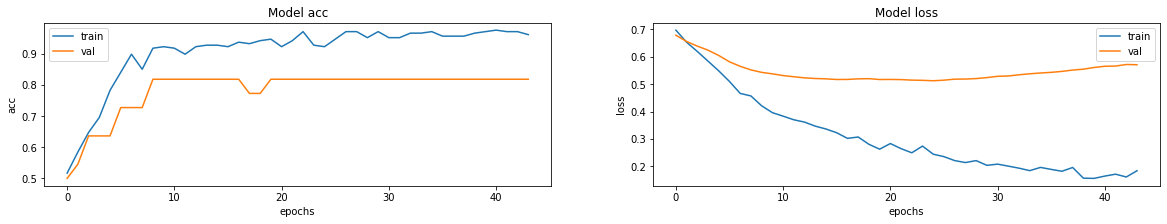

In [ ]:
import pandas as pd
m = []
batchsize = 5
print("Batchsize:", batchsize)
for k in range(4, 11):
    gc.collect()
    pet_folder = DATA_DIR / f'pet/3d-folds/50/fold-{k}'
    mri_folder = DATA_DIR / f'mri/3d-folds/50/fold-{k}'
    xtrain1 = np.load(pet_folder / 'xtrain.npy')
    ytrain1 = np.load(pet_folder / 'ytrain.npy')
    xtest1 = np.load(pet_folder/ 'xtest.npy')
    ytest1 = np.load(pet_folder/ 'ytest.npy')
    xtrain = np.load(mri_folder / 'xtrain.npy')
    ytrain = np.load(mri_folder / 'ytrain.npy')
    xtest = np.load(mri_folder/ 'xtest.npy')
    ytest = np.load(mri_folder/ 'ytest.npy')
    tf.keras.backend.clear_session()
    print('k =',k)

    results = DATA_DIR / f'pet/3d-folds/merged/results/fold-{k}'
    results.mkdir(exist_ok=True, parents=True)
    history,metrics,predictions = train_merged_cv(k, xtrain1, xtrain, ytrain1, xtest1, ytest, xtest, ytest1, batch_size=4, run_name=f"merged{k}", filename=str(results / "merged-cv.h5"), verbose=2)
    f = open(DATA_DIR / results / f'{k}.txt','w')
    f.writelines(str(predictions))
    f.close()
    
    print(predictions)
    m.append(metrics)
    plot_results(history)
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(results/f'{k}-history.csv')

f = open(DATA_DIR / results /'merged-metrics.txt','w')
f.writelines(str(m))
f.close()

In [ ]:
batchsize = 4
print("Batchsize:", batchsize)
for k in range(1, 11):
    pet_folder = DATA_DIR / f'pet/3d-folds/50/fold-{k}'
    mri_folder = DATA_DIR / f'mri/3d-folds/50/fold-{k}'
    xtrain1 = np.load(pet_folder / 'xtrain.npy')
    ytrain1 = np.load(pet_folder / 'ytrain.npy')
    xtest1 = np.load(pet_folder/ 'xtest.npy')
    ytest1 = np.load(pet_folder/ 'ytest.npy')
    xtrain = np.load(mri_folder / 'xtrain.npy')
    ytrain = np.load(mri_folder / 'ytrain.npy')
    xtest = np.load(mri_folder/ 'xtest.npy')
    ytest = np.load(mri_folder/ 'ytest.npy')
    tf.keras.backend.clear_session()
    print('k =',k)

    results = DATA_DIR / f'pet/3d-folds/merged/results/fold-{k}'
    results.mkdir(exist_ok=True, parents=True)
    metrics,predictions = train_merged(xtrain, xtrain1, ytrain1, xtest, ytest, xtest1, ytest1, batch_size=4, run_name=f"fold-{k}", filename=str(results / "merged.h5"), verbose=0)